In [1]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
res = requests.get('https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json')
data = json.loads(res.text)
df = pd.DataFrame(data)
ssn = df['smoothed_ssn']
ssn.head(10)

0     -1.0
1     -1.0
2     -1.0
3     -1.0
4     -1.0
5     -1.0
6    135.9
7    137.9
8    140.2
9    143.8
Name: smoothed_ssn, dtype: float64

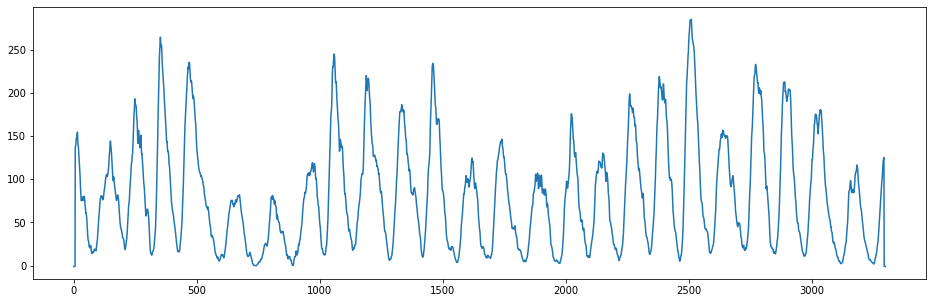

In [5]:
plt.figure(figsize=(16, 5))
plt.plot(ssn)
plt.show()

In [11]:
window = 1000
kernel = np.ones(window) / window
conv = np.convolve(ssn, kernel, mode='same')

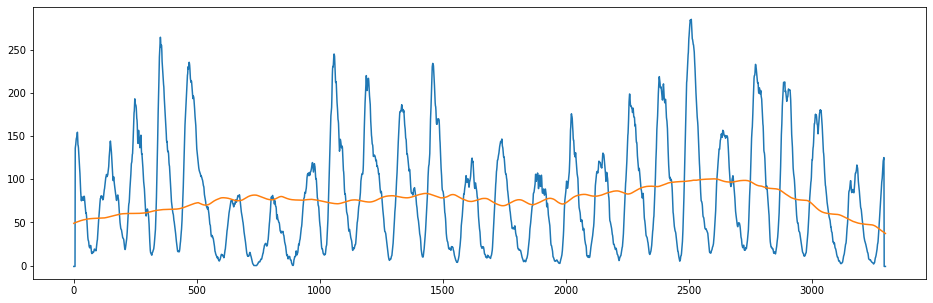

In [12]:
plt.figure(figsize=(16, 5))
plt.plot(ssn)
plt.plot(conv)
plt.show()

In [15]:
n = len(ssn)

In [18]:
fhat = np.fft.fft(ssn, n)
fhat

array([268388.8           +0.j        ,   5348.78847225+15998.37048587j,
       -12417.44630357+14023.11108475j, ...,
        -3349.54108599+39662.63118316j, -12417.44630357-14023.11108475j,
         5348.78847225-15998.37048587j])

In [19]:
ABS = np.abs(fhat)
ABS

array([268388.8       ,  16868.82913316,  18730.73989989, ...,
        39803.81561934,  18730.73989989,  16868.82913316])

In [20]:
PDS = fhat * np.conj(fhat)
PDS

array([7.20325480e+10+0.j, 2.84557396e+08+0.j, 3.50840617e+08+0.j, ...,
       1.58434374e+09+0.j, 3.50840617e+08+0.j, 2.84557396e+08+0.j])

In [22]:
freq = np.fft.fftfreq(n, 1)
freq

array([ 0.        ,  0.00030303,  0.00060606, ..., -0.00090909,
       -0.00060606, -0.00030303])

In [24]:
pos_indices = np.arange(1, n // 2)
pos_indices

array([   1,    2,    3, ..., 1647, 1648, 1649])

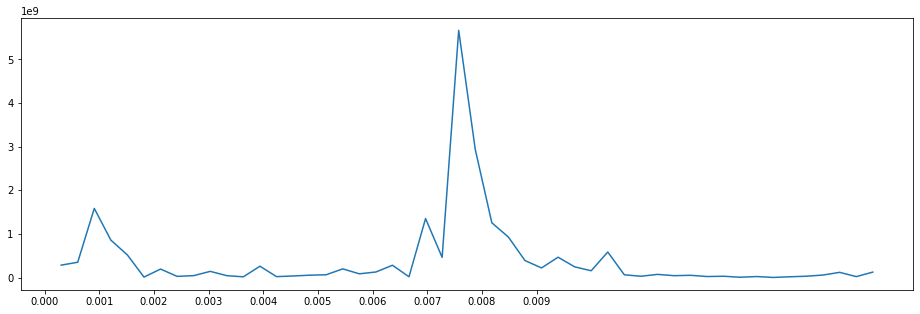

In [30]:
plt.figure(figsize=(16, 5))
plt.xticks(np.arange(0, 0.01, 0.001))
plt.plot(np.abs(freq[pos_indices[:50]]), np.abs(PDS[pos_indices[:50]]))
plt.show()

In [38]:
freq_filter = PDS[pos_indices].real > 1.5e9
freq_filter

array([False, False,  True, ..., False, False, False])

In [43]:
clean_indices = np.array([3, 25])

In [44]:
frequencies = freq[clean_indices]
frequencies

array([0.00090909, 0.00757576])

In [45]:
abs_amplitudes = ABS[clean_indices]
abs_amplitudes

array([39803.81561934, 75255.13771441])

In [46]:
angles = np.angle(fhat[clean_indices])
angles

array([-1.65504722, -0.64735799])

In [69]:
loop_synthetic_abs_signal = np.zeros(n)
for f, a, p in zip(frequencies, abs_amplitudes, angles):
    t = np.arange(0, n, 1)
    amplitude = a / (n / 2)
#     phase = 2*np.pi*50*f + p # Shift 50 to the right and add additionaly shift of each separate sin-curve
    loop_synthetic_abs_signal += amplitude * np.cos(2*np.pi*f*t + p)
    
loop_synthetic_abs_signal

array([34.35149786, 35.75641632, 37.07610921, ..., 29.65507517,
       31.29767475, 32.86422978])

[]

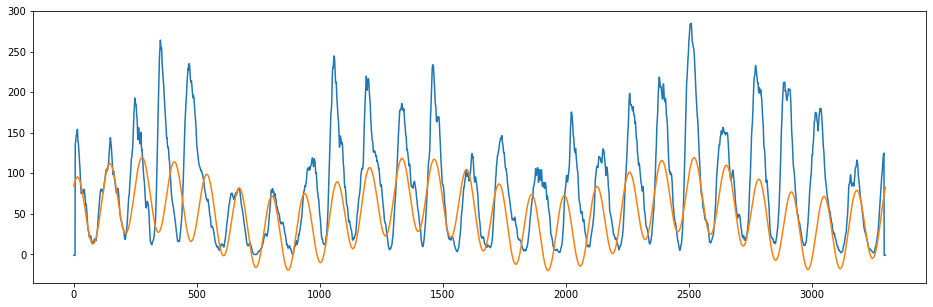

In [82]:
plt.figure(figsize=(16, 5))
plt.plot(ssn)
plt.plot(t, loop_synthetic_abs_signal + 50)
plt.plot()

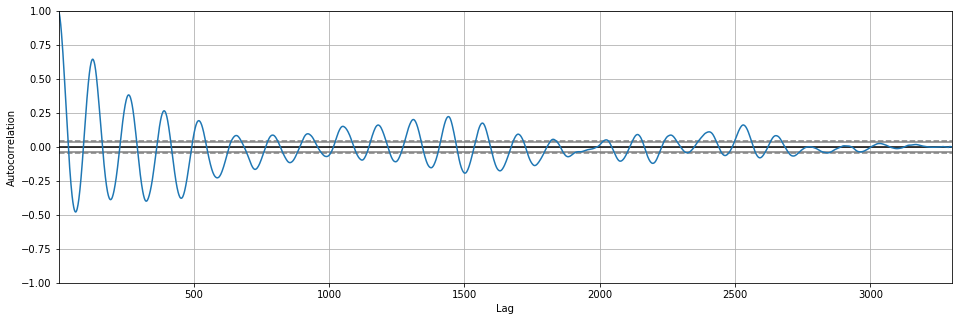

In [75]:
plt.figure(figsize=(16, 5))
pd.plotting.autocorrelation_plot(ssn)
plt.show()

In [80]:
lags = range(1, n)
autocorr_values = [ssn.autocorr(lag=lag) for lag in lags]
autocorr_values

[0.9968227286569138,
 0.9903533930801106,
 0.9812100054199436,
 0.9696101931035126,
 0.9556482815931037,
 0.939413546939075,
 0.9223886183809101,
 0.9033499317900019,
 0.8823291518047329,
 0.8594321177850482,
 0.8349280262451046,
 0.8092457275642664,
 0.7826451551605648,
 0.7550767132936338,
 0.7264202586537123,
 0.6966181406900464,
 0.6656588209765839,
 0.6336891458836342,
 0.6008929503340006,
 0.5673828394736198,
 0.5333049325390106,
 0.49878990542427865,
 0.4638837674130468,
 0.42860295610435406,
 0.39302019610505085,
 0.35713917164916337,
 0.32098820232008685,
 0.28475551218029693,
 0.24859549389253316,
 0.21258564014377399,
 0.17676149777117203,
 0.14121949239667583,
 0.10606873074157741,
 0.07135222283107848,
 0.03717924825661114,
 0.0036731779561134828,
 -0.029081967238389444,
 -0.06099783992350328,
 -0.09199253269539762,
 -0.12202019772029575,
 -0.15106095934543054,
 -0.17909022044211712,
 -0.20602809446109252,
 -0.23186157546782454,
 -0.2566282572109469,
 -0.28029095608945215,

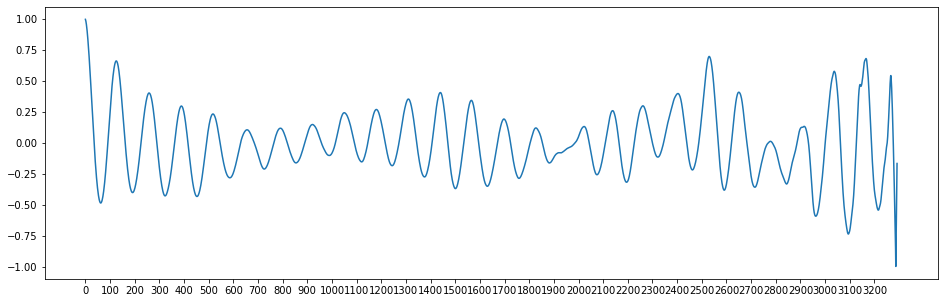

In [143]:
plt.figure(figsize=(16, 5))
plt.xticks(np.arange(0, 3300, 100))
plt.plot(autocorr_values)
plt.show()

In [152]:
autocorr_values[1]

0.9903533930801106

In [150]:
autocorr_values[125]

0.6610551949197898

In [146]:
autocorr_values[62]

-0.4857863746113748

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin

In [480]:
class SineCosineTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, frequencies, amplitudes, phases):
        self.frequencies = frequencies
        self.amplitudes = amplitudes
        self.phases = phases
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        result = X.copy()
        
        for idx, (f, a, p) in enumerate(zip(self.frequencies, self.amplitudes, self.phases)):
            result[f'sin_{idx}'] = a * np.sin(2*np.pi*X.index*f + p)
            result[f'cos_{idx}'] = a * np.cos(2*np.pi*X.index*f + p)
            
        return result

In [481]:
transformer = SineCosineTransformer(frequencies, abs_amplitudes / (n / 2), angles)
transformer.get_params()

{'amplitudes': array([24.12352462, 45.60917437]),
 'frequencies': array([0.00090909, 0.00757576]),
 'phases': array([-1.65504722, -0.64735799])}

In [482]:
a = transformer.transform(pd.DataFrame(ssn))
a

,smoothed_ssn,sin_0,cos_0,sin_1,cos_1
0,-1.0,-24.037958,-2.030025,-27.506028,36.381523
1,-1.0,-24.049162,-1.892688,-25.743771,37.649104
2,-1.0,-24.059580,-1.755289,-23.923195,38.831399
3,-1.0,-24.069214,-1.617834,-22.048426,39.925727
4,-1.0,-24.078062,-1.480325,-20.123710,40.929611
5,-1.0,-24.086125,-1.342768,-18.153407,41.840777
6,135.9,-24.093402,-1.205167,-16.141981,42.657159
7,137.9,-24.099893,-1.067527,-14.093989,43.376909
8,140.2,-24.105597,-0.929852,-12.014068,43.998397
9,143.8,-24.110515,-0.792147,-9.906933,44.520214


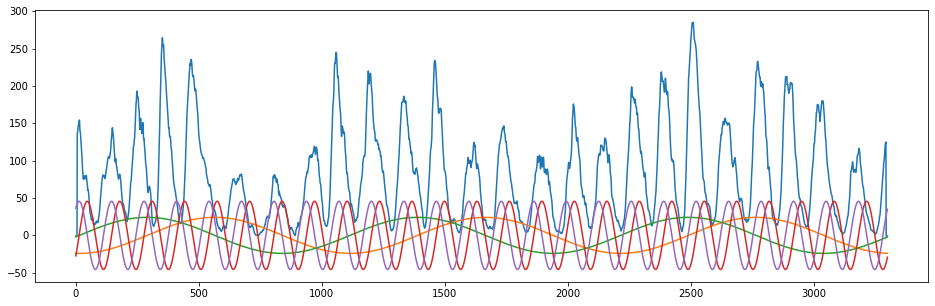

In [483]:
plt.figure(figsize=(16, 5))
plt.plot(a['smoothed_ssn'])
plt.plot(a['sin_0'])
plt.plot(a['cos_0'])
plt.plot(a['sin_1'])
plt.plot(a['cos_1'])
plt.show()

In [484]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [485]:
column_transformer = ColumnTransformer(
    transformers=[
        ('sine_cosine', SineCosineTransformer(frequencies, abs_amplitudes / (n / 2), angles), ['time']),
        ('lag', OnlineLagTransformer([1, 125, 62]), ['time'])
    ],
    remainder='passthrough'
)

In [486]:
pipeline = Pipeline([
    ('sine_cosine', SineCosineTransformer(frequencies, abs_amplitudes / (n / 2), angles)),
    ('scaler', StandardScaler())
])

In [602]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(np.arange(0, 3300, 1), columns=['time']), ssn, test_size=0.25, shuffle=False)

In [603]:
pipeline.fit(X_train)

Pipeline(memory=None,
         steps=[('sine_cosine',
                 SineCosineTransformer(amplitudes=array([24.12352462, 45.60917437]),
                                       frequencies=array([0.00090909, 0.00757576]),
                                       phases=array([-1.65504722, -0.64735799]))),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

In [604]:
X_train_processed = pd.DataFrame(pipeline.transform(X_train), columns=['time', 'sin0', 'cos0', 'sin1', 'cos1'])

In [605]:
X_train_processed.head()

,time,sin0,cos0,sin1,cos1
0,-1.731351,-1.300501,-0.212150,-0.873497,1.125383
1,-1.729951,-1.301158,-0.204015,-0.818619,1.164526
2,-1.728552,-1.301768,-0.195876,-0.761925,1.201035
3,-1.727152,-1.302333,-0.187734,-0.703544,1.234827
4,-1.725753,-1.302851,-0.179589,-0.643607,1.265827


In [606]:
X_train_processed.head()

,time,sin0,cos0,sin1,cos1
0,-1.731351,-1.300501,-0.212150,-0.873497,1.125383
1,-1.729951,-1.301158,-0.204015,-0.818619,1.164526
2,-1.728552,-1.301768,-0.195876,-0.761925,1.201035
3,-1.727152,-1.302333,-0.187734,-0.703544,1.234827
4,-1.725753,-1.302851,-0.179589,-0.643607,1.265827


In [607]:
def transform_window(y, window=900):
    result_y = []
    for i in range(len(y) - window):
        result_y.append(y[i:i + window])
        
    return result_y

In [608]:
window_y_train = transform_window(y_train.tolist())
window_y_test = transform_window(y_test.tolist())

In [609]:
from sklearn.linear_model import LinearRegression

In [610]:
model = LinearRegression()
model.fit(X_train_processed[:-900], window_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [611]:
X_test_processed = pd.DataFrame(pipeline.transform(X_test), columns=['time', 'sin0', 'cos0', 'sin1', 'cos1'])
X_test_processed.head()

,time,sin0,cos0,sin1,cos1
0,1.732751,-0.010646,1.331990,-1.149887,-0.847454
1,1.734150,-0.002597,1.332654,-1.189360,-0.793036
2,1.735550,0.005456,1.333271,-1.226177,-0.736817
3,1.736950,0.013512,1.333842,-1.260256,-0.678924
4,1.738349,0.021571,1.334366,-1.291517,-0.619489


In [612]:
X_test_processed.head()

,time,sin0,cos0,sin1,cos1
0,1.732751,-0.010646,1.331990,-1.149887,-0.847454
1,1.734150,-0.002597,1.332654,-1.189360,-0.793036
2,1.735550,0.005456,1.333271,-1.226177,-0.736817
3,1.736950,0.013512,1.333842,-1.260256,-0.678924
4,1.738349,0.021571,1.334366,-1.291517,-0.619489


In [613]:
preds = model.predict(X_test_processed)

In [614]:
preds

array([[ 9.44053947e+01,  9.51876836e+01,  9.60138086e+01, ...,
         5.24135678e+01,  5.00295712e+01,  4.77472608e+01],
       [ 9.58849522e+01,  9.67026165e+01,  9.75608576e+01, ...,
         5.01218146e+01,  4.78264905e+01,  4.56381986e+01],
       [ 9.73984013e+01,  9.82479350e+01,  9.91347046e+01, ...,
         4.79190865e+01,  4.57175862e+01,  4.36282464e+01],
       ...,
       [ 1.17613189e+02,  1.18068595e+02,  1.18469077e+02, ...,
        -4.99058047e+00, -3.50012174e+00, -1.87068134e+00],
       [ 1.18773225e+02,  1.19161104e+02,  1.19491802e+02, ...,
        -3.39849517e+00, -1.78561186e+00, -3.73889334e-02],
       [ 1.19866000e+02,  1.20184131e+02,  1.20442969e+02, ...,
        -1.68403205e+00,  4.76620052e-02,  1.91077681e+00]])

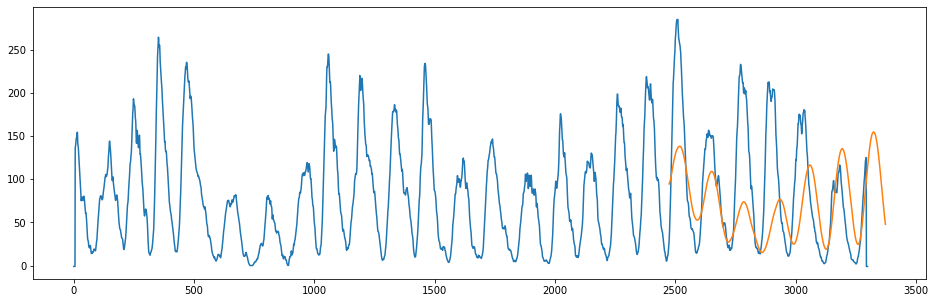

In [615]:
plt.figure(figsize=(16, 5))
plt.plot(ssn)
# plt.plot(loop_synthetic_abs_signal + 50)
plt.plot(np.arange(2474, 3374, 1), preds[0])
plt.show()

In [616]:
preds = model.predict(X_train_processed)

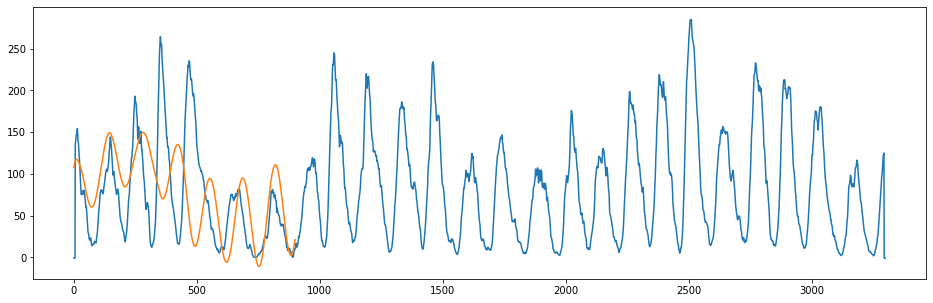

In [617]:
plt.figure(figsize=(16, 5))
plt.plot(ssn)
plt.plot(preds[0])
plt.show()